<div class='alert alert-success'>
    <h1 align="center">Local Search Algorithms: Genetic Algorithm for N-Queens</h1> 
    <h3 align="center">Artificial Intelligece Course (Fall 2021)</h3>
    <h5 align="center">Seyed Naser RAZAVI <a href='http://www.snrazavi.ir/ai-slides/'>(website)</a></h5>
</div>

In [1]:
import tqdm
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

from nqueens import NQueensStatePermutation as NQueensState
from nqueens import create_animation

# for animation
from matplotlib import animation, rc
rc('animation', html='html5')

plt.rcParams['figure.figsize'] = (6, 6)

## N-Queens Problem
- **Goal**: Place N queens on a N-by-N chess board so that no two queens can attack each other.
- Thus a solution requires that no two queens share the same row, column or diagonal.

<p align="center">
    <img src="imgs/Four-Queens-Local-Search.png" width="80%">
</p>
<h6 align="center">4-Queens problem</h6>

### Problem formulation: First formulation
- **States**: each column contains only one queen.
- **Actions**: move a queen to another row in its column.
- **State Space Size**: $N^N$


### Problem formulation: Second formulation (Permuatation)
- **States**: each column and each row contains only one queen.
- **Actions**: move a queen to another row in its column which is not occupied.
- **State Space Size**: $N!$

In [2]:
state = NQueensState.random_state(N=8)
print(state)

[1, 7, 4, 3, 8, 6, 2, 5] <4>


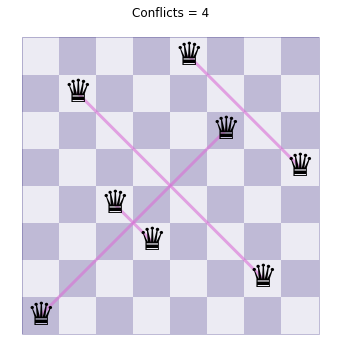

In [3]:
state.plot(show_conflicts=True)

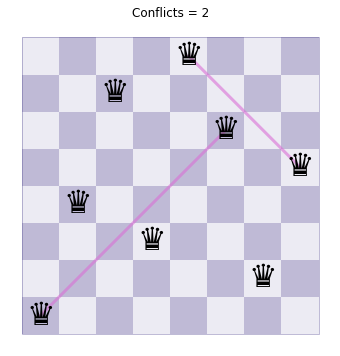

In [4]:
best_neighbor = state.best_neighbor()
best_neighbor.plot(show_conflicts=True)

In [5]:
best_neighbor

NQueensStatePermutation(queens=[1, 4, 7, 3, 8, 6, 2, 5])

## Genetic Algorithm
<img src="imgs/genetic_algorithm.png" width="80%">

### Selection, Crossover, Mutation
<img src='imgs/GA_cycle.png' width='100%'>

In [6]:
class GeneticAlgorithm:
    
    def __init__(self):
        self.population = []    
        self.history, self.bests, self.means = [], [], []

    def tournament_selection(self, k=2):
        samples = [random.choice(self.population) for _ in range(k)]
        return min(samples, key=lambda x: x.conflicts())

    @staticmethod
    def mutate(chromosome):
        """ Swap mutation which randomly swaps two genes."""
        N = chromosome.N
        offspring = NQueensState(queens=chromosome.queens)
        i = random.randint(0, N - 2)
        j = random.randint(i + 1, N - 1)

        p = random.random()
        if p < 0.8:
            offspring.queens[i], offspring.queens[j] = offspring.queens[j], offspring.queens[i]
        elif p < 0.9:
            offspring.queens[i: j + 1] = reversed(offspring.queens[i: j + 1])
        else:
            random.shuffle(offspring.queens[i: j + 1])

        offspring.conflicts()
        return offspring

    @staticmethod
    def crossover(parent1, parent2):
        """Order 1 crossover."""

        def next(idx, N):
            return (idx + 1) % N

        N = parent1.N
        child1 = NQueensState(queens=parent1.queens)
        child2 = NQueensState(queens=parent2.queens)

        i = random.randint(0,   N - 2)
        j = random.randint(i+1, N - 1)

        # create child1
        k1 = k2 = j
        count = j - i
        while count < N:
            if parent2.queens[k1] not in child1.queens[i:j]:
                child1.queens[k2] = parent2.queens[k1]
                k1 = next(k1, N)
                k2 = next(k2, N)
                count += 1
            else:
                k1 = next(k1, N)

        child1.conflicts()

        # create child2
        k1 = k2 = j
        count = j - i
        while count < N:
            if parent1.queens[k1] not in child2.queens[i:j]:
                child2.queens[k2] = parent1.queens[k1]
                k1 = next(k1, N)
                k2 = next(k2, N)
                count += 1
            else:
                k1 = next(k1, N)

        child2.conflicts()

        return child1, child2
    
    
    def search(self, N=100, pop_size=300, max_generations=200, k=None, pc=0.9, pm=0.8):
        if k is None:
            k = max(2, int(0.2 * pop_size))

        # create random initial population
        self.population = [NQueensState.random_state(N=N) for _ in range(pop_size)]

        # report statistics
        best = min(self.population, key=lambda x: x.conflicts())
        mean = sum([x.conflicts() for x in self.population]) / pop_size
        self.history.append(best)
        self.bests.append(best.conflicts())
        self.means.append(mean)

        pbar = tqdm.tqdm(range(1, max_generations + 1), 
                                  desc='Generation 0', 
                                  total=max_generations)
        for i in pbar:
            if best.conflicts() == 0: 
                break

            new_population = []

            for j in range(pop_size // 2):
                # Select parents
                parent1 = self.tournament_selection(k)
                parent2 = self.tournament_selection(k)

                # crossover
                if random.random() < pc:
                    child1, child2 = self.crossover(parent1, parent2)
                else:
                    child1 = NQueensState(queens=parent1.queens)
                    child2 = NQueensState(queens=parent2.queens)

                # mutation
                if random.random() < pm:
                    child1 = self.mutate(child1)
                if random.random() < pm:
                    child2 = self.mutate(child2)

                new_population += [child1, child2]

            self.population = new_population

            # report statistics
            best = min(self.population, key=lambda x: x.conflicts())
            mean = sum([x.conflicts() for x in self.population]) / pop_size
            pbar.set_description(f'Generation {i:3d} | best {best.conflicts():3d} | mean {mean:.2f}')

            self.history.append(best)
            self.bests.append(best.conflicts())
            self.means.append(mean)

            # Stop if optimal solution found
            if best.conflicts == 0: 
                break

        return best
     
    def __call__(self, N=100, pop_size=300, max_generations=200, k=None, pc=0.9, pm=0.8):
        return self.search(N, pop_size, max_generations, k, pc, pm)
    
    def plot_fitness(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.means, label='Average')
        plt.plot(self.bests, label='Best')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.legend(loc='best')
        plt.show()

In [7]:
# GA parameters
N = 30
pop_size = 100
max_generations = 500

p_crossover = 0.9
p_mutation = 0.8

# run GA
ga = GeneticAlgorithm()

best_solution = ga(
    N=N, 
    pop_size=pop_size, 
    max_generations=max_generations,
    pc=p_crossover,
    pm=p_mutation
)

# show results
print(f"Best Solution Found with <{best_solution.conflicts()}> conflicts:\n{best_solution}")

Generation  53 | best   0 | mean 3.67:  11%|█         | 53/500 [00:01<00:14, 31.90it/s]

Best Solution Found with <0> conflicts:
[7, 12, 6, 24, 20, 17, 14, 27, 22, 28, 19, 4, 30, 13, 9, 25, 5, 1, 23, 16, 8, 11, 3, 29, 15, 26, 18, 21, 10, 2] <0>


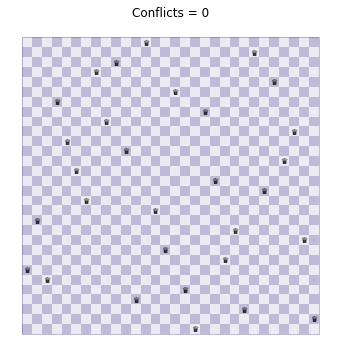

In [8]:
best_solution.plot(show_conflicts=True)

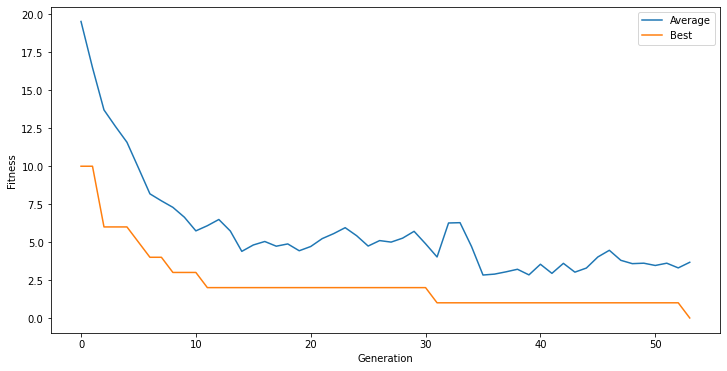

In [9]:
ga.plot_fitness()

## Animation

In [10]:
anim = create_animation(ga.history)
anim.save(f'imgs/{N}-queens-ga.gif', writer='imagemagick')
clear_output()

<img src="imgs/30-queens-ga.gif" width="50%">

In [12]:
anim = create_animation(ga.history, plot_objective=True)
anim.save(f'imgs/{N}-queens-ga-with-objective.gif', writer='imagemagick')
clear_output()

<img src="imgs/30-queens-ga-with-objective.gif">